In [1]:
import numpy as np

import torch
import torch_geometric

seed = 12345

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Generacja zdarzeń
Na początku weźmy dla przykładu cztery zdarzenia dla pikselów XY = [[0, 0], [0, 1], [1, 0], [1, 1]], z czasami T [0, 0.1, 0.2, 0.3] oraz atrybutami P [5, 6, 7, 8]. Generujemy tensor zdarzeń [ev0, ev1, ev2, ev3].

In [2]:
# Tworzenie 4 różnych zdarzeń
ev0 = [0, 0, 0, 5]
ev1 = [0, 1, 0.1, 6]
ev2 = [1, 0, 0.2, 7]
ev3 = [1, 1, 0.3, 8]

# Tworzenie wektora/tensora zdarzeń
events = torch.tensor([ev0, ev1, ev2, ev3])
print(events)

tensor([[0.0000, 0.0000, 0.0000, 5.0000],
        [0.0000, 1.0000, 0.1000, 6.0000],
        [1.0000, 0.0000, 0.2000, 7.0000],
        [1.0000, 1.0000, 0.3000, 8.0000]])


Z każdego zdarzenia tworzymy wierzchołki grafu o pozycji pos = [X, Y, T] oraz wartości x = [P]. Zapisujemy to w formacie Data z biblioteki PyTorch Geometric.

In [3]:
from torch_geometric.data import Data

x, pos = events[:, -1:], events[:, :3]
data = Data(x=x, pos=pos)

print('Cały format danych: ', data)
print('Atrybuty wierzchołków: ', data.x)
print('Pozycje wierzchołków: ', data.pos)

Cały format danych:  Data(x=[4, 1], pos=[4, 3])
Atrybuty wierzchołków:  tensor([[5.],
        [6.],
        [7.],
        [8.]])
Pozycje wierzchołków:  tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.1000],
        [1.0000, 0.0000, 0.2000],
        [1.0000, 1.0000, 0.3000]])


Teraz "generujemy" krawędzie pomiędzy wierzchołkami/zdarzeniami. Na początku tworzymy graf skierowany, gdzie zdarzenia ev1, ev2 oraz ev3 są skierowane w stronę zdarzenia ev0. Oznacza to, że informacje będą propagowane od wierzchołków ev1, ev2, ev3 do ev0 -> tylko ev0 zmieni swoją wartość x.

Pierwszy wiersz odnosi się do indeksu wierzchołka, z którego wychodzi krawędź, a drugi wiersz wierzchołek docelowy. Indeksy odnoszą się do wektora x oraz pos.

In [4]:
edge_index = torch.tensor([[1, 2, 3], [0, 0, 0]])
data.edge_index = edge_index

print('Cały format danych: ', data)
print('Indeksy sąsiedztwa: ', data.edge_index)

Cały format danych:  Data(x=[4, 1], pos=[4, 3], edge_index=[2, 3])
Indeksy sąsiedztwa:  tensor([[1, 2, 3],
        [0, 0, 0]])


# Warstwy konwolucyjne - PointNetConv

Ogólna zasada działania warstw konwolucyjnych na grafie określa propagację informacji do wierzchołka grafu na podstawie wartości sąsiadujących wierzchołków oraz wartości krawędzi ich łączących (obie wartości są opcjonalne). Konwolucja definiowana jest w 3 funkcjach:
- message function - tworzy ona wiadomość (informację) dla dla każdego sąsiadującego wierzchołka, która następnie zostanie przesłana do aktualnego wierzchołka.
- aggregation function - na podstawie wiadomości (informacji) uzyskanych przez wszystkich sąsiadów, agreguje je do jednej wartości, która zostanie wykorzystana do aktualizacji wierzchołka. Przeważnie są to funkcje max, min, mean z wszystkich wartości od sąsiadów.
- update function - aktualizuje ona informację danego wierzchołka na podstawie zagregowanych informacji.

Jest to ogólny zarys działania konwolucji na grafie. Możliwe są różne wariancje tych funkcji, mogą one być opcjonalne, oraz wykorzystane informację zależą od reprezentacji.

Jest wiele różnych stron, które to dokładniej tłumaczą:
- https://danielegrattarola.github.io/posts/2021-03-12/gnn-lecture-part-2.html
- https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html

Teraz tworzymy klasę warstwy konwolucyjnej. My raczej będziemy korzystać z konwolucji PointNetConv - jest ona prosta, szybka, dostosowana do przetwarzania danych typu PointCloud. Taka warstwa PointNetConv przyjmuje 3 argumenty:
- local_nn - jest to warstwa wejściowa typu MLP, która mapuje dane wejściowe sąsiada równe (x oraz różnicy pos sąsiada względem docelowego wierzchołka
- global_nn - jest to warstwa wyjściowa typu MLP, przetwarza dane po funckji agregacji, które nadpiszą x sąsiada
- add_self_loop - dodaje do wektora sąsiedztwa dla każdego wierzchołka połączenie ze sobą, tzn (idx_ev0, idx_ev0)

Dokładny opis tej konwolucji jest w dokumentacji:
https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.PointNetConv.html

oraz jego implementacja w pythonie:
https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/point_conv.html#PointNetConv

In [5]:
from torch.nn import Linear
from torch.nn.functional import relu
from torch_geometric.nn.conv import PointNetConv
from torch_geometric.nn.norm import BatchNorm

class PointNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, add_loop):
        super().__init__()

        self.local_nn = Linear(in_channels + 3, out_channels)
        self.conv = PointNetConv(self.local_nn, add_self_loops=add_loop)
        self.norm = BatchNorm(in_channels = out_channels)

    def forward(self, x, pos, edge_index):
        x = self.conv(x, pos, edge_index)

        # Na wyjściu takiej warstwy mamy aktualizację wartości x. Można ją poddać aktywacji funkcji oraz normalizacji:
        # x = relu(x)      # Activation
        # x = self.norm(x) # Normalization 
        return x

Tworzymy pojedynczą warstwę konwolucyjną przy założeniu, że nie dodajemy self_loops. Możemy określić ilość wejść (pierwsza warstwa ma tylko jedną cechę x dla każdego wierzchołka) oraz wyjściową ilość cech. Na razie ustalimy przejście z 1 -> 1.

Podajemy jako wejście sieci wartości x, pos oraz krawędzie edge_index grafu wejściowego. W wyniku dostajemu zaktualizowane wartości x.

In [6]:
conv = PointNetBlock(1, 1, False)

new_x = conv(data.x, data.pos, data.edge_index)

print(data.x)
print(new_x)

tensor([[5.],
        [6.],
        [7.],
        [8.]])
tensor([[-2.1661],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]], grad_fn=<ScatterReduceBackward0>)


Tutaj spróbujemy zrobić dokładnie to samo, ale z przejściem 1 -> 4:

In [7]:
conv = PointNetBlock(1, 4, False)

new_x = conv(data.x, data.pos, data.edge_index)

print(data.x)
print(new_x)

tensor([[5.],
        [6.],
        [7.],
        [8.]])
tensor([[-3.0979, -0.5534, -1.2027,  0.8512],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]],
       grad_fn=<ScatterReduceBackward0>)


Ponieważ krawędzie tworzą graf skierowany, gdzie wierzchołek pierwszy, drugi i trzeci skierowane są w stronę wierzchołka zerowego, tylko wierzchołek zerowy ma aktualizowaną wartość. 

Implementacja takich warstw najpierw generuje wektor wyjściowy zerowy a następnie go aktualizuje odpowiednio na podstawie wyniku konwolucji dla wierzchołkow, które mają sąsiadów. Ponieważ pozostałe wierzchołki nie mają żadnego sąsiada, aby mogłaby zostać zaktualizowana wartość, pozostają one zerowe.

Można spróbować ręcznie zduplikować wartości, aby nie były zerami, tylko wartościami przed konwolucją:

In [8]:
new_x[1:, :] = data.x[1:] # Uwzględniamy tylko indeksy tych wierzchołków, które nie były zmienione
print(new_x)

tensor([[-3.0979, -0.5534, -1.2027,  0.8512],
        [ 6.0000,  6.0000,  6.0000,  6.0000],
        [ 7.0000,  7.0000,  7.0000,  7.0000],
        [ 8.0000,  8.0000,  8.0000,  8.0000]], grad_fn=<CopySlices>)


W przypadku self_loop = True nie ma takiego problemu, ponieważ każdy wierzchołek będzie miał minimum jednego sąsiada - samego siebie.

In [9]:
conv = PointNetBlock(1, 4, True)

new_x = conv(data.x, data.pos, data.edge_index)

print(data.x)
print(new_x)

tensor([[5.],
        [6.],
        [7.],
        [8.]])
tensor([[ 2.4808, -1.2056, -0.7681, -2.4180],
        [ 1.3959, -1.5472, -0.8319, -2.8610],
        [ 1.6172, -1.7461, -0.8958, -3.3039],
        [ 1.8385, -1.9450, -0.9596, -3.7469]],
       grad_fn=<ScatterReduceBackward0>)


# Generacja grafu - rzeczywiste dane

Zaczniemy najpierw od wczytania rzeczywistych danych. Jest to przykład ze zbioru danych N-Caltech101 o klasie Lotos. Jest to plik binarny, dlatego trzeba go też odpowiednio przetworzyć przesuwając bity. W wyniku mamy wektor events z danymi X, Y, T i P.

Warto tutaj od razu czas znormalizować np. do zakresu od 0 do 100.

In [10]:
raw_file = 'data/lotus.bin'

f = open(raw_file, 'rb')
raw_data = np.fromfile(f, dtype=np.uint8)
f.close()

raw_data = np.uint32(raw_data)
all_y = raw_data[1::5]
all_x = raw_data[0::5]
all_p = (raw_data[2::5] & 128) >> 7  # bit 7
all_ts = ((raw_data[2::5] & 127) << 16) | (raw_data[3::5] << 8) | (raw_data[4::5])
all_ts = all_ts / 1e6  # µs -> s

# Normalization to range from 0 to 100
all_ts = (all_ts - all_ts.min()) * (100 / all_ts.max()) 

all_p = all_p.astype(np.float64)
all_p[all_p == 0] = -1
events = np.column_stack((all_x, all_y, all_ts, all_p))
events = torch.from_numpy(events).float()

print('X: ', events[:,0].numpy())
print('Y: ', events[:,1].numpy())
print('T: ', events[:,2].numpy())
print('P: ', events[:,3].numpy())

X:  [ 53. 124.  54. ...  72. 134.  10.]
Y:  [ 67.   2. 107. ... 102. 111.  21.]
T:  [0.0000000e+00 2.6985697e-02 7.7625528e-02 ... 9.9929703e+01 9.9933365e+01
 9.9948364e+01]
P:  [ 1.  1. -1. ...  1.  1. -1.]


Następnie, tak jak poprzednio, na podstawie surowych danych zdarzeniowych tworzymy obiekt Data, który składa się z atrybutu 'x' oraz pozycji 'pos'. Tutaj również można zmodyfikować ilość zdarzeń jakie chcemy uwzględnić (aktualnie są to wszystkie zdarzenia, ale można to zmienić do zakresu  [:] -> [10000:20000] na przykład)

In [11]:
x, pos = events[:, -1:], events[:, :3] 
data = Data(x=x, pos=pos)

print(data)

Data(x=[46151, 1], pos=[46151, 3])


Już teraz można zwizualizować te dane przy pomocy zwykłej spłaszczonej klatki lub grafu składającego się z samych wierzchołków.

### Chmura punktów

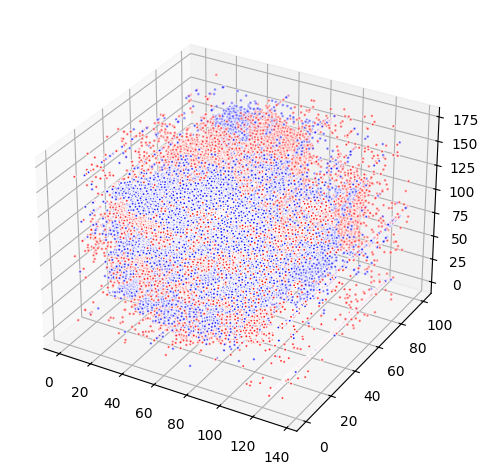

In [12]:
import matplotlib.pyplot as plt


def plot_graf(data):
    # Create the 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically


    x, y, t = data.pos.numpy().T
    ax.scatter(x, t, y, s=5, ec="w", c=data.x, cmap='bwr')
    fig.tight_layout()
    plt.show()

plot_graf(data)

### Klatka

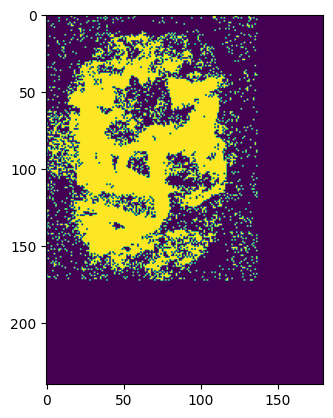

In [13]:
def plot_frame(data):
  img_shape = np.array([240, 180])
  
  pos_x = data.pos.numpy()[:, 0]
  pos_y = data.pos.numpy()[:, 1]

  vec = np.zeros(img_shape)
  for x, y, p in zip(pos_x, pos_y, data.x):
    vec[int(y), int(x)] = 255

  plt.imshow(vec)
  plt.show()

plot_frame(data)

Teraz należy wygenerować krawędzie pomiędzy wierzchołkami. Do tego służy funkcja radius_graph z biblioteki PyTorch Geometrics. 

https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.RadiusGraph.html#torch_geometric.transforms.RadiusGraph

Dziala ona na całym grafie. Jako parametr podaje się odległość poszukiwania 'r' oraz 'max_num_neighbors', która ogranicza maksymalną ilość sąsiadów dla jednego wierzchołka. 

Aby dodać pojedynczy, nowy wierzchołek do aktualnego grafu, stosowałem funkcję radius z tej samej biblioteki. Jednak (subiektywnie) sama implementacja takiej funkcji nie jest bardzo skomplikowana.

https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.radius.html#torch_geometric.nn.pool.radius

In [14]:
from torch_geometric.nn import radius_graph

data.edge_index = radius_graph(data.pos, r=5, max_num_neighbors=16)

print('Generated edges: \n', data.edge_index.numpy())

print('Number of edges = ', len(data.edge_index.numpy()[0]))

Generated edges: 
 [[   52    21    77 ... 45101 45903 45670]
 [    0     0     0 ... 46148 46150 46150]]
Number of edges =  655016


Na podstawie wygenerowanych krawędzi możemy sprawdzić sąsiadów przychodzących i wychodzących z losowego wierzchołka (przykładowo 1234). Wyznaczone zostaną indeksy tych sąsiadów oraz dostans pomiędzy nimi.

In [15]:
selected_idx = 1234

selected_vec = data.edge_index==selected_idx

print('Index of nodes from ', selected_idx)
from_vec = data.edge_index[0].numpy()[selected_vec[1]]
print(from_vec)

for idx in from_vec:
    pos_diff = data.pos.numpy()[selected_idx] - data.pos.numpy()[idx]
    pos_diff = pos_diff ** 2
    pos_diff = pos_diff.sum()
    pos_diff = np.sqrt(pos_diff)

    print('Idx from = ', idx, 'Idx to = ', selected_idx, 'Dist = ', pos_diff)

##############################################################################3

print('Index of nodes to ', selected_idx)
to_vec = data.edge_index[1].numpy()[selected_vec[0]]
print(to_vec)

for idx in to_vec:
    pos_diff = data.pos.numpy()[selected_idx] - data.pos.numpy()[idx]
    pos_diff = pos_diff ** 2
    pos_diff = pos_diff.sum()
    pos_diff = np.sqrt(pos_diff)

    print('Idx from = ', selected_idx, 'Idx to = ', idx, 'Dist = ', pos_diff)

Index of nodes from  1234
[1321  976 2058 3005  817  875 2302  743]
Idx from =  1321 Idx to =  1234 Dist =  1.0266068
Idx from =  976 Idx to =  1234 Dist =  4.1784205
Idx from =  2058 Idx to =  1234 Dist =  4.5021124
Idx from =  3005 Idx to =  1234 Dist =  4.6607685
Idx from =  817 Idx to =  1234 Dist =  4.278086
Idx from =  875 Idx to =  1234 Dist =  4.5700984
Idx from =  2302 Idx to =  1234 Dist =  4.81338
Idx from =  743 Idx to =  1234 Dist =  4.6836457
Index of nodes to  1234
[ 817  875  976 1321]
Idx from =  1234 Idx to =  817 Dist =  4.278086
Idx from =  1234 Idx to =  875 Dist =  4.5700984
Idx from =  1234 Idx to =  976 Dist =  4.1784205
Idx from =  1234 Idx to =  1321 Dist =  1.0266068


Można zauważyć, że liczba sąsiadów przychodzacych do wierzchołka o indeksie 1234 jest inna niż liczba wierzchołków z którymi sąsiaduje wierzchołek 1234. Jest to spowodowane tym, że potencjalni sąsiedzi tego wierzchołka już posiadają maksymalną liczbę sąsiadów. 

Przykładowo można sprawdzić indeks 2058, który znajduje się tylko w jednej liście powyżej.

In [16]:
selected_vec = data.edge_index.numpy()==2058

print('Number of neighbors of node :', selected_vec[1].sum())

Number of neighbors of node : 16


# Pooling

Ostatnim kluczowym elementem grafowych sieci konwolucyjnych są warstwy poolujące. Mają one dwa zastosowania, pierwsze jest podobne jak w przypadku tradycyjnych CNN, czyli redukcja wymiarowości danych, ilości parametrów i wymagania obliczeniowego.

Drugim, bardzo istotnym zastosowaniem takich sieci jest sprawienie, aby z nieregularnych danych o potencjalnie różnej liczbie wierzchołków, stworzyć wektor cech o stałym rozmiarze, które można następnie zastosować w klasyfikatorze lub detektorze (np. YOLO head).


Takie warstwy działają w następujący sposób:
- najpierw dzieli się cały graf na odpowiednie fragmenty/klastry. Najprostszą metodą jest podzielenie takiego grafu na woksele o ustalonym rozmiarze. W tym celu stosuje się funkcję voxel_grid z torch_geometric.nn.pool: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.voxel_grid.html#torch_geometric.nn.pool.voxel_grid. Podaje się mu jako parametr wartości 'pos' danych oraz rozmiar voxela w każdym wymiarze.
- następnie generowany jest nowy wierzchołek dla każdej grupy/klastra/voxela, który będzie go reprezentował. Istnieją tutaj różne rodzaje, jednak najlepszą i najprostszą jest wersja max_pooling. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.max_pool.html#torch_geometric.nn.pool.max_pool. Wartość wierzchołka jest wartością maksymalną w całej grupie, pozycja jest wartością średnią, a indeksy krawędzi są definiowane jako połączenie indeksów krawędzi wszystkich węzłów w tym samym klastrze

In [17]:
from torch_geometric.nn.pool import max_pool, voxel_grid
from torch_geometric.transforms import Cartesian

class MaxPooling(torch.nn.Module):

    def __init__(self, size):
        super(MaxPooling, self).__init__()
        self.voxel_size = list(size)

    def forward(self, data):
        cluster = voxel_grid(data.pos[:, :2], size=self.voxel_size)
        data_new = Data(x=data.x, pos=data.pos, edge_index=data.edge_index)
        data_new = max_pool(cluster, data=data_new)  # transform for new edge attributes
        return data_new

Dla przykłady wygenerujemy warstwy poolujące o rozmiarze voxeli 2x2x2, 4x4x4 i 8x8x8. Ponieważ jest to warstwa typu MAX, większość wierzchołków będzie miała wartości polaryzacji dodatnie (czyli czerwone). Dlatego wykorzystanie takiej warstwy na początku może wpłynąć negatywnie na dalsze wyniki.

Data(x=[46151, 1], pos=[46151, 3], edge_index=[2, 655016])


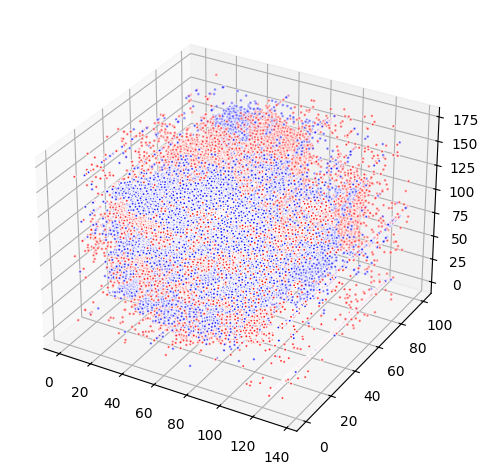

In [18]:
print(data)
plot_graf(data)

DataBatch(x=[3993, 1], edge_index=[2, 44033], pos=[3993, 3])


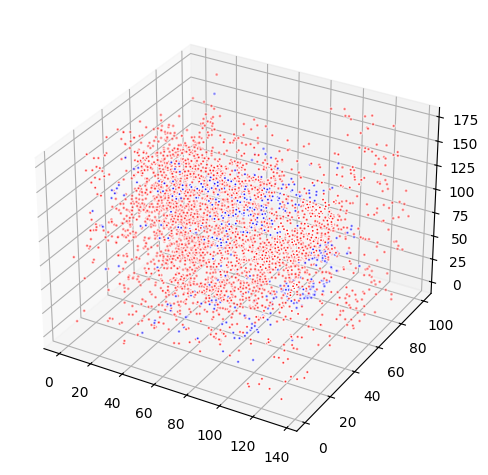

In [19]:
MaxPool2 = MaxPooling([2, 2])
data_pool2 = MaxPool2(data)

print(data_pool2)
plot_graf(data_pool2)

DataBatch(x=[1334, 1], edge_index=[2, 6833], pos=[1334, 3])


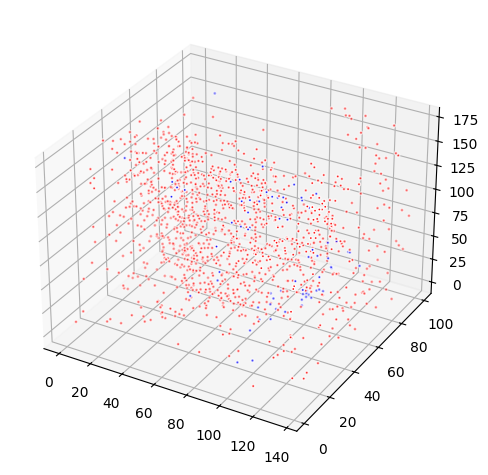

In [20]:
MaxPool4 = MaxPooling([4, 4])
data_pool4 = MaxPool4(data)
print(data_pool4)
plot_graf(data_pool4)

DataBatch(x=[387, 1], edge_index=[2, 1881], pos=[387, 3])


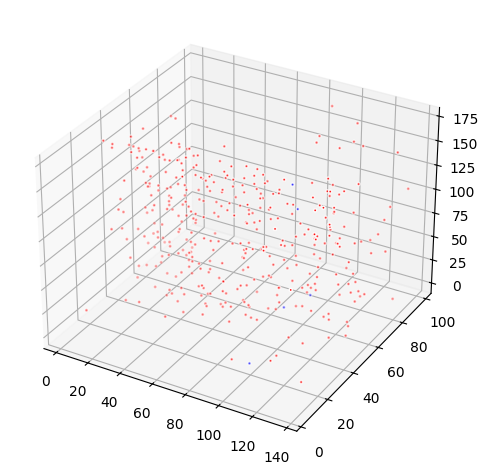

In [21]:
MaxPool8 = MaxPooling([8, 8])
data_pool8 = MaxPool8(data)

print(data_pool8)
plot_graf(data_pool8)

W celu uzyskania wektora cech po części ekstraktora cech, stosowana jest inna warstwa poolująca. Ponieważ chcemy uzyskać wektor cech o ustalonej długości, rozmiar voxeli musimy uzależnić od rozmiaru całego grafu, aby uzyskać stałą wartość voxeli.

Dodatkowo, jedyne co nas interesuje to same wartości wierzchołków, nie musimy ustalać pozycji nowych wierzchołków. Dlatego możemy zastosować metodę 'max_pool_x', która zwróci nam jedynie wartości x wierzchołków.

In [22]:
from torch_geometric.nn.pool import max_pool_x, voxel_grid

class MaxPoolingX(torch.nn.Module):

    def __init__(self, voxel_size, size):
        super(MaxPoolingX, self).__init__()
        self.voxel_size = voxel_size
        self.size = size

    def forward(self, data):
        cluster = voxel_grid(data.pos[:,:2], size=self.voxel_size)
        x, _ = max_pool_x(cluster, data.x, torch.zeros(len(data.x)), size=self.size)
        return x

Aby wywołać taką warstwę, należy podać wymaganą liczbę cech na wyjściu i na jej podstawie wyliczyć rozmiary voxeli. Wartość ta będzie stała dla wszystkich danych, więc wystarczy ją wyliczyć na początku dzieląc rozdzielczość kamery przez pierwiastek wyjść.

In [23]:
img_shape = [240, 180] # Size of image in XY

size = 4 # Number of output features

img_shape_div = [x // np.sqrt(size) for x in img_shape]

max_pool_out = MaxPoolingX(img_shape_div, size=size)
x = max_pool_out(data)

print(x)

tensor([[1.],
        [1.],
        [1.],
        [1.]])


# Przykładowa sieć

Na koniec zdefiniujemy prostą sieć GCNN. Będzie się ona składała z 6 warstw konwolucyjnych, 2 warstw poolujących oraz 1 warstwy poolującej wyjściowej. Następnie całość zostanie przetworzona przez warstwę fully conected layer, która imituje prosty klasyfikator.

Liczba wejść takiej sieci jest równa iloczynowi liczby cech na wyjściu warstwy pooolującej wyjściowej oraz ilości kanałów ostatniej warstwy konwolucyjnej.

Dla zobrazowania jak zmieniają się dane, wyświelimy 'data' po każdej konwolucji i poolingu.

In [24]:
from torch.nn import Linear

class GraphConvNN(torch.nn.Module):
    def __init__(self, output_feature=4, output_fc=100):
        super(GraphConvNN, self).__init__()

        img_shape = [240, 180] # Size of image in XY
        img_shape_div = [x // np.sqrt(output_feature) for x in img_shape]

        self.conv1 = PointNetBlock(1, 2, True)
        self.conv2 = PointNetBlock(2, 4, True)

        self.pooling1 = MaxPooling([2, 2])

        self.conv3 = PointNetBlock(4, 8, True)
        self.conv4 = PointNetBlock(8, 16, True)

        self.pooling2 = MaxPooling([4, 4])

        self.conv5 = PointNetBlock(16, 32, True)
        self.conv6 = PointNetBlock(32, 64, True)

        self.pooling_out = MaxPoolingX(img_shape_div, size=output_feature)

        self.fc = Linear(output_feature * 64, output_fc) # Input size is equal to output features times number of last channels of conv layer

    def forward(self, data):
        print('Original data: \t', data)
        data.x = self.conv1(data.x, data.pos, data.edge_index)
        print('Conv1 data: \t', data)
        data.x = self.conv2(data.x, data.pos, data.edge_index)
        print('Conv2 data: \t', data)

        data = self.pooling1(data)
        print('Pooling1 data: \t', data)

        data.x = self.conv3(data.x, data.pos, data.edge_index)
        print('Conv3 data: \t', data)
        data.x = self.conv4(data.x, data.pos, data.edge_index)
        print('Conv4 data: \t', data)

        data = self.pooling2(data)
        print('Pooling2 data: \t', data)

        data.x = self.conv5(data.x, data.pos, data.edge_index)
        print('Conv5 data: \t', data)
        data.x = self.conv6(data.x, data.pos, data.edge_index)
        print('Conv6 data: \t', data)

        x = self.pooling_out(data)
        x = x.view(-1, self.fc.in_features)
        return self.fc(x)

        

GCNN = GraphConvNN()

x, pos = events[:, -1:], events[:, :3] 
data = Data(x=x, pos=pos)
data.edge_index = radius_graph(data.pos, r=5, max_num_neighbors=16)


output = GCNN(data)

print('Output size: \t', output.size())

Original data: 	 Data(x=[46151, 1], pos=[46151, 3], edge_index=[2, 655016])
Conv1 data: 	 Data(x=[46151, 2], pos=[46151, 3], edge_index=[2, 655016])
Conv2 data: 	 Data(x=[46151, 4], pos=[46151, 3], edge_index=[2, 655016])
Pooling1 data: 	 DataBatch(x=[3993, 4], edge_index=[2, 44033], pos=[3993, 3])
Conv3 data: 	 DataBatch(x=[3993, 8], edge_index=[2, 44033], pos=[3993, 3])
Conv4 data: 	 DataBatch(x=[3993, 16], edge_index=[2, 44033], pos=[3993, 3])
Pooling2 data: 	 DataBatch(x=[1334, 16], edge_index=[2, 6833], pos=[1334, 3])
Conv5 data: 	 DataBatch(x=[1334, 32], edge_index=[2, 6833], pos=[1334, 3])
Conv6 data: 	 DataBatch(x=[1334, 64], edge_index=[2, 6833], pos=[1334, 3])
Output size: 	 torch.Size([1, 100])


W wyniku uzyskaliśmy wektor cech o długości 100, która nastepnie może zostać poddana funkcji strat i wykorzystana do uczenia.